<a href="https://colab.research.google.com/github/buxkirill/reboot_DA/blob/main/final_project/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime, date, timedelta
import requests
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from matplotlib.patches import Ellipse
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objects as go
import plotly.express as px
from bs4 import BeautifulSoup
import numpy as np
warnings.filterwarnings('ignore')
# формат чисел
# pd.options.display.float_format ='{:,.3f}'.format

In [2]:
def get_current_inflation():
  """
  Парсим сайт уровень-инфляции.рф
  В таблице находим строку с уровнем инфляции на последние "12 месяцев)"
  Из этой таблицы берем % инфляции
  """
  response = requests.get('https://уровень-инфляции.рф')
  soup = BeautifulSoup(response.text, 'lxml')
  text = soup.find('table').get_text()
  return np.float64(text[text.find('12 месяцев)') + 11:text.find('12 месяцев)') + 15])

def get_current_key_rate():
  df = pd.read_html('https://www.cbr.ru/hd_base/KeyRate/')[0]
  tax_rate = pd.read_html('https://www.cbr.ru/hd_base/KeyRate/')[0].iloc[0]['Ставка']
  return tax_rate/100

# Постановка задачи

Определение доходности облигаций по данным ММВБ
Disclaimer: данное задание подготовлено исключительно для тренировки навыков
анализа данных, результаты выполнения задания не являются рекомендациями по
операциям с облигациями, автор задания не является инвестиционным
консультантом.
Имеются данные по облигациям, которые торгуются на ММВБ на текущую дату.
Требуется выполнить следующие действия с данными по облигациям на дату
формирования данных:
1. Оценить рынок рублевых облигаций по распределению купонной доходности,
предложить разделение на кластеры по купонной доходности.
Предложить графическое представление полученных групп/кластеров. (график)
2. По низкорисковым рублевым облигациям с датой промежуточной выплаты по
купонам не более 20% купонного периода назад до текущей даты и облигациям
выпущенным в аналогичный период, рассчитать доходность последующих
купонов по отобранным облигациям с учетом разницы номинала и цены продажи,
а также с учетом налоговых отчислений на период год с текущей дата. (график
и/или таблица).
3. Допускается обоснованное изменение условий как по критериям оценки рынка,
так с учетом выбранной стратегии инвестирования.
Датасет с данными расположен по адресу:
https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.
%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&li
mit=unlimited&lang=ru
На усмотрение слушателя:
• можно скачать и загрузить в вашем скрипте файл csv (например,
pd.read_csv с указанием русской кодировки, релевантного знака
сепарирования и номера строки заголовков),
• загружать on-line:
s=requests.get(bond_url).content
pd.read_csv(io.StringIO(s.decode('УКАЗАТЬ КОДИРОВКУ')), sep='СЕПАПРАТОР', header=№ СТРОКИ
ЗАГОЛОВКОВ)
Могут быть использованы следующие поля (а также все остальные) в любых
комбинациях:

'SECID' - Код ценной бумаги,
'SHORTNAME' - Краткое наименование,
'NAME' Полное наименование,
'FACEVALUE' - Номинальная стоимость,
FACEUNIT' - валюта,
'DURATION' - дюрация,
'IS_QUALIFIED_INVESTORS' - признак продукта для квалифицированных инвесторов,
'HIGH_RISK' - признак уровня риска,
'COUPONFREQUENCY' – число купонов в год,
'COUPONDATE' - Дата выплаты купона,
'COUPONPERCENT' - Ставка купона, %,
'COUPONVALUE' - Сумма купона, в валюте номинала, 
'OFFERDATE' - Дата оферты,
'EMITENTNAME' – наименование эмитента,
'INN' – ИНН эмитента,
'PRICE' – текущий % от FACEVALUE,
'PRICE_RUB' - котировка,

Пояснения:
1. Для получения текущей даты можно использовать метод datetime.date.today();

2. Период расчета доходности рекомендуется выбирать 365 дней с текущей даты;

3. Нужно учитывать накопленный купонный доход (НКД) и разницу котировки и номинала ;

4. В общем случае процентный доход при ставке НДФЛ 13% будет
Profit =(Цена_Номинальная – Цена_покупки – НКД + 0.87*Купонный_доход_руб*X_лет)*100% /(Цена_покупки + НКД) (комиссией брокера
пренебрегаем)

5. Период расчета НКД: df['COUPONDAYSPASSED']/df['COUPONLENGTH'] , рекомендуется
выбирать меньше или равный 0.2.
Если удовлетворяет условию, полученная величина умножается
на COUPONPERCENT/COUPONFREQUENCY.

6. Датасет содержит данные, которые нужно преобразовывать в форматы python, а также
пустые и искаженные данные, с которыми нужно что-то решить.

# Описание данных

Текстовые:
1. **SECID** - Код ценной бумаги. non-null
2. **SHORTNAME**- Краткое наименование. non-null
3. '**NAME**' - Полное наименование. non-null
4. '**ISIN**' - ISIN код. non-null
5. '**PRIMARY_BOARD_TITLE**' - Режим торгов. non-null
6. '**REGNUMBER**' - номер выпуска. 
7. '**EMITENTNAME**' – наименование эмитента. 
8. '**INN**' – ИНН эмитента. 

Бинарные:
9. 'IS_COLLATERAL' - . non-null
10. '**IS_EXTERNAL**' - внешний. non-null
11. '**EVENINGSESSION**' - Вечерняя сессия. non-null
12. **IS_QUALIFIED_INVESTORS** - признак продукта для 
квалифицированных инвесторов. non-null
13. '**HIGH_RISK**' - признак уровня риска. non-null

Категориальные:
14. '**LISTLEVEL**' - Уровень листинга
15. '**TYPENAME**' - Вид/категория ценной бумаги. non-null
16. '**FACEUNIT**' - валюта. non-null
17. '**PRIMARY_BOARDID**' - Идентификатор режима торгов. non-null
18. '**SECSUBTYPE**' - Подтип облигации. очень много null
19. 'IS_RII' - . очень много null

Временные:
20. '**MATDATE**' - Дата погашения
21. '**ISSUEDATE**' - Дата начала торгов
22. '**COUPONDATE**' - Дата выплаты купона
23. '**ISSUEDATE.1**' - Дата начала торгов
24. '**STARTDATEMOEX**' - Дата начала торгов на Московской Бирже
25. '**OFFERDATE**' - Дата оферты

Вещественные:
26. '**FACEVALUE**' - Номинальная стоимость. non-null
27. '**INITIALFACEVALUE**' - Номинальная стоимость. non-null
28. '**DAYSTOREDEMPTION**' - Дней до погашения
29. '**LOTSIZE**' - Размер лота, ц.б. non-null
30. '**PRICE**' – текущий % от FACEVALUE
31. '**PRICE_RUB**' - котировка
32. '**DURATION**' - дюрация
33. '**COUPONFREQUENCY**' – число купонов в год
34. '**YIELDATWAP**' - Доходность по средневзвешенной цене. очень много null
35. '**COUPONPERCENT**' - Ставка купона
36. '**COUPONVALUE**' - Сумма купона
37. '**COUPONDAYSPASSED**' - прошло дней с выплаты купона
38. '**COUPONDAYSREMAIN**' - дней до выплаты купона
39. '**COUPONLENGTH**' - периодичность выплаты купона
40. '**ISSUESIZE**' - Объем выпуска

Прочие:
41. 'RTL1'
42. 'RTH1'
43. 'RTL2'
44. 'RTH2'
45. 'RTL3'
46. 'RTH3'
47. 'DISCOUNT1' non-null
48. 'LIMIT1'
49. 'DISCOUNT2'
50. 'LIMIT2'
51. 'DISCOUNT3'
52. 'DISCOUNTL0'
53. 'DISCOUNTH0'

# 1.Загрузка и предобработка данных от 08.10.2021

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=1kerEidv4dqdOUqeKHDgGHidY5uHZohGn' -O './rates.csv'

KEY_RATE = get_current_key_rate()
INFLATION_RATE = get_current_inflation()
INVEST_PERIOD = 365
TAX_RATE = 0.13

In [4]:
df = pd.read_csv('rates.csv', sep=';', header=1, encoding='cp1251', dtype={'INN': 'string', 'LISTLEVEL': 'object'})
df.sample(5)

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,IS_COLLATERAL,IS_EXTERNAL,PRIMARY_BOARDID,PRIMARY_BOARD_TITLE,MATDATE,IS_RII,DURATION,ISSUEDATE,EVENINGSESSION,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,YIELDATWAP,COUPONDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,ISSUEDATE.1,INITIALFACEVALUE,SECSUBTYPE,STARTDATEMOEX,DAYSTOREDEMPTION,OFFERDATE,EMITENTNAME,INN,LOTSIZE,PRICE,PRICE_RUB,RTL1,RTH1,RTL2,RTH2,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0
1626,RU000A1026E7,СберИОС332,СберИОС 001Р-332R 5Г СРВП,Биржевые облигации,RU000A1026E7,4B02-341-01481-B-001P,3,"1000,0",RUB,2365597.0,0,0,TQCB,Т+: Облигации - безадрес.,07.10.2025,NaN,1460.0,01.10.2020,0,0,0,NaN,"0,0",07.10.2025,"0,010","0,5",372.0,1460.0,1832.0,01.10.2020,"1000,0",NaN,2020-10-01,1460.0,NaN,"Публичное акционерное общество ""Сбербанк России""",7707083893,1,"83,49","834,9",NaN,"1669,8",NaN,"1669,8",NaN,"1669,8","100,0",NaN,NaN,NaN,NaN,NaN,NaN
488,RU000A0JY031,МФ МарЭл17,Респ.Марий Эл 2017обл.08,Региональные облигации,RU000A0JY031,RU35008MAR0,1,"1000,0",RUB,2000000.0,0,0,TQCB,Т+: Облигации - безадрес.,21.08.2024,NaN,522.0,30.08.2017,0,0,0,4.0,"8,13",24.11.2021,"8,600","21,44",44.0,47.0,91.0,30.08.2017,"1000,0",NaN,2017-08-30,1048.0,NaN,Министерство финансов Республики Марий Эл,1200000874,1,"100,9","1019,37",NaN,"2038,74",NaN,"2038,74",NaN,"2038,74","100,0",NaN,NaN,NaN,NaN,"10,00","10,00"
1465,RU000A101UL7,ГЕНЕТИКБ01,ЦГРМ ГЕНЕТИКО,Биржевые облигации,RU000A101UL7,4B02-01-00549-R,3,"1000,0",RUB,145000.0,0,0,TQCB,Т+: Облигации - безадрес.,23.06.2025,NaN,904.0,29.06.2020,0,0,0,4.0,"11,86",27.12.2021,"14,000","34,9",11.0,80.0,91.0,29.06.2020,"1000,0",NaN,2020-06-29,1354.0,NaN,"Акционерное общество ""Центр Генетики и Репроду...",9731078633,1,"106,27","1066,92",NaN,"2133,84",NaN,"2133,84",NaN,"2133,84","100,0",NaN,NaN,NaN,NaN,NaN,NaN
2174,RU000A103L03,СамолетP10,ГК Самолет БО-П10,Биржевые облигации,RU000A103L03,4B02-10-16493-A-001P,1,"1000,0",RUB,15000000.0,0,0,TQCB,Т+: Облигации - безадрес.,21.08.2024,NaN,923.0,25.08.2021,0,0,0,4.0,"9,58",24.11.2021,"9,150","22,81",44.0,47.0,91.0,25.08.2021,"1000,0",NaN,2021-08-25,1048.0,NaN,"публичное акционерное общество ""Группа компани...",9731004688,1,"99,71","1008,13",NaN,"2016,26",NaN,"2016,26",NaN,"2016,26","100,0",NaN,NaN,NaN,NaN,NaN,NaN
414,RU000A0JXK99,ТрансФ1P02,ТрансФин-М ПАО 001P-02,Биржевые облигации,RU000A0JXK99,4B02-02-50156-A-001P,2,"1000,0",RUB,789874.0,0,0,TQCB,Т+: Облигации - безадрес.,22.02.2027,NaN,145.0,06.03.2017,0,0,0,2.0,"7,34",28.02.2022,"7,500","37,4",39.0,143.0,182.0,06.03.2017,"1000,0",NaN,2017-03-06,1963.0,2022-03-03,"Публичное акционерное общество ""ТрансФин-М""",7708797192,1,"99,08","998,81",NaN,"1997,62",NaN,"1997,62",NaN,"1997,62","100,0",NaN,NaN,NaN,NaN,"10,00","10,00"


In [5]:
CATEGORICAL_COLS = ['TYPENAME', 'LISTLEVEL', 'FACEUNIT', 'PRIMARY_BOARDID', 'SECSUBTYPE', 'IS_RII']

BINARY_COLS = ['IS_COLLATERAL', 'IS_EXTERNAL', 'IS_QUALIFIED_INVESTORS', 'EVENINGSESSION', 'HIGH_RISK']

DATE_COLS = ['MATDATE', 'ISSUEDATE', 'COUPONDATE', 'ISSUEDATE.1', 'STARTDATEMOEX', 'OFFERDATE']

COLS_CONVERT_TO_FLOAT = ['FACEVALUE', 'COUPONPERCENT', 'COUPONVALUE', 'PRICE', 'PRICE_RUB', 'RTL1', 'RTH1', 'RTL2', 'RTH2', 'RTL3', 'RTH3', 'DISCOUNT1', 'DISCOUNT2', 'DISCOUNT3', 'DISCOUNTL0', 'DISCOUNTH0']

In [6]:
# изменяем формат временных колонок
for col in DATE_COLS:
  df[col] = pd.to_datetime(df[col])

# изменяем формат численных колонок
for col in COLS_CONVERT_TO_FLOAT:
  df[col] = df[col].str.replace(',', '.').astype('float64')


In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.isna().sum()

# 2.Кластеризация

Попробуем сделать кластеризацию по бинарным, категориальным признакам + 'PRICE', 'COUPONPERCENT'

### 2.1 Кластеризация всех облигаций

Создадим временный датафрейм для кластеризации. Преобразуем категориальные признаки через get_dummies

In [10]:
clustering_df = df.copy()
clustering_df = pd.get_dummies(clustering_df[CATEGORICAL_COLS + BINARY_COLS + ['PRICE', 'COUPONPERCENT']], columns=CATEGORICAL_COLS).dropna()

Отмасштабируем признаки

In [11]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_df)

Выберем оптимальное количество кластеров методом локтя по атрибуту inertia_

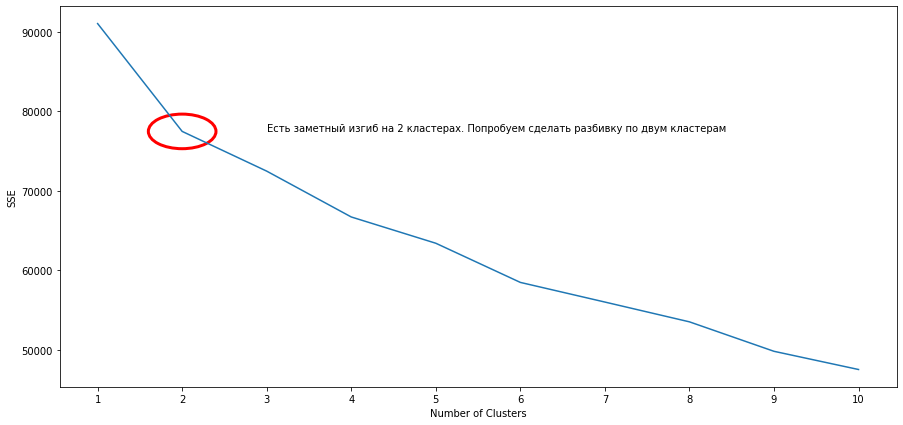

In [12]:
sse = []
kmeans_kwargs = {"init": "random",
                "n_init": 10,
                "max_iter": 300,
                "random_state": 999}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(15,7))
ellipse = Ellipse((2, sse[1]), 
                  height=(max(sse) - min(sse)) / len(sse), 
                  width=0.8,
                  edgecolor='r',
                  fill=False,
                  linewidth=3)

ax.text(x=3, y=sse[1], s='Есть заметный изгиб на 2 кластерах. Попробуем сделать разбивку по двум кластерам')
ax.plot(range(1, 11), sse)
ax.add_patch(ellipse)
ax.set_xticks(range(1, 11))
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE")

plt.show()

Обучаем модель на 2 кластера. Получаем разбиение

In [13]:
kmeans = KMeans(init="random",
                n_clusters=2,
                n_init=10,
                max_iter=300,
                random_state=999)

kmeans.fit(scaled_features)
clustering_df['Cluster'] = kmeans.labels_
clustering_df.Cluster.value_counts()

1    2086
0     310
Name: Cluster, dtype: int64

Посмотрим на описание 0 и 1 класса

In [14]:
clustering_df[clustering_df.Cluster==0].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Еврооблигации МинФина,TYPENAME_Коммерческая облигация,TYPENAME_Корпоративные еврооблигации,TYPENAME_Корпоративные облигации,TYPENAME_Муниципальные облигации,TYPENAME_ОБР,TYPENAME_ОФЗ,TYPENAME_Облигации государств,TYPENAME_Региональные облигации,LISTLEVEL_1,LISTLEVEL_2,LISTLEVEL_3,FACEUNIT_CHF,FACEUNIT_CNY,FACEUNIT_EUR,FACEUNIT_GBP,FACEUNIT_RUB,FACEUNIT_USD,PRIMARY_BOARDID_OBBO,PRIMARY_BOARDID_PSAU,PRIMARY_BOARDID_PSBB,PRIMARY_BOARDID_RPMO,PRIMARY_BOARDID_TQCB,PRIMARY_BOARDID_TQIR,PRIMARY_BOARDID_TQIU,PRIMARY_BOARDID_TQOB,PRIMARY_BOARDID_TQOD,PRIMARY_BOARDID_TQOE,PRIMARY_BOARDID_TQRD,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Структурные облигации,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.0,310.000000,310.00000,310.0,310.0,310.0,310.000000,310.0,310.000000,310.0,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.0,310.0,310.0,310.000000,310.000000,310.0,310.000000,310.0,310.000000,310.000000,310.0,310.0,310.0,310.000000,310.0,310.0,310.0
mean,0.300000,0.993548,0.648387,0.645161,0.003226,102.630548,5.886081,0.029032,0.048387,0.0,0.822581,0.06129,0.0,0.0,0.0,0.038710,0.0,0.064516,0.0,0.670968,0.029032,0.003226,0.119355,0.006452,0.119355,0.722581,0.0,0.0,0.0,0.264516,0.109677,0.0,0.003226,0.0,0.538710,0.083871,0.0,0.0,0.0,0.087097,0.0,0.0,0.0
std,0.458998,0.080192,0.478246,0.479238,0.056796,10.780493,3.027671,0.168168,0.214930,0.0,0.382641,0.24025,0.0,0.0,0.0,0.193214,0.0,0.246067,0.0,0.470621,0.168168,0.056796,0.324730,0.080192,0.324730,0.448449,0.0,0.0,0.0,0.441788,0.312992,0.0,0.056796,0.0,0.499305,0.277642,0.0,0.0,0.0,0.282433,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,45.240000,0.010000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
25%,0.000000,1.000000,0.000000,0.000000,0.000000,99.212500,4.000000,0.000000,0.000000,0.0,1.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
50%,0.000000,1.000000,1.000000,1.000000,0.000000,102.115000,5.375000,0.000000,0.000000,0.0,1.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
75%,1.000000,1.000000,1.000000,1.000000,0.000000,105.657500,7.500000,0.000000,0.000000,0.0,1.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,164.970000,19.000000,1.000000,1.000000,0.0,1.000000,1.00000,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0


In [15]:
clustering_df[clustering_df.Cluster==1].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Еврооблигации МинФина,TYPENAME_Коммерческая облигация,TYPENAME_Корпоративные еврооблигации,TYPENAME_Корпоративные облигации,TYPENAME_Муниципальные облигации,TYPENAME_ОБР,TYPENAME_ОФЗ,TYPENAME_Облигации государств,TYPENAME_Региональные облигации,LISTLEVEL_1,LISTLEVEL_2,LISTLEVEL_3,FACEUNIT_CHF,FACEUNIT_CNY,FACEUNIT_EUR,FACEUNIT_GBP,FACEUNIT_RUB,FACEUNIT_USD,PRIMARY_BOARDID_OBBO,PRIMARY_BOARDID_PSAU,PRIMARY_BOARDID_PSBB,PRIMARY_BOARDID_RPMO,PRIMARY_BOARDID_TQCB,PRIMARY_BOARDID_TQIR,PRIMARY_BOARDID_TQIU,PRIMARY_BOARDID_TQOB,PRIMARY_BOARDID_TQOD,PRIMARY_BOARDID_TQOE,PRIMARY_BOARDID_TQRD,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Структурные облигации,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.0,2086.0,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.0,2086.00000,2086.000000,2086.000000,2086.000000,2086.0,2086.0,2086.0,2086.0,2086.000000,2086.000000,2086.0,2086.0,2086.0,2086.0,2086.000000,2086.000000,2086.0,2086.000000,2086.0,2086.0,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.0
mean,0.132790,0.008629,0.083413,0.033557,0.076702,98.417589,6.068413,0.765101,0.0,0.0,0.011026,0.140460,0.004794,0.001438,0.022531,0.0,0.05465,0.254554,0.156280,0.589166,0.0,0.0,0.0,0.0,0.990412,0.009588,0.0,0.0,0.0,0.0,0.899329,0.058485,0.0,0.023969,0.0,0.0,0.018217,0.022531,0.002876,0.017737,0.001438,0.007191,1.0
std,0.339429,0.092513,0.276572,0.180129,0.266182,13.833235,4.194630,0.424038,0.0,0.0,0.104449,0.347547,0.069088,0.037905,0.148439,0.0,0.22735,0.435715,0.363208,0.492103,0.0,0.0,0.0,0.0,0.097470,0.097470,0.0,0.0,0.0,0.0,0.300965,0.234715,0.0,0.152990,0.0,0.0,0.133766,0.148439,0.053567,0.132027,0.037905,0.084513,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.010000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,96.980000,0.962500,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,99.900000,7.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,100.930000,8.800000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,1.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,198.210000,16.310000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.00000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


##### Различие между кластерами

Получилось неплохо разбить облигации на 2 класса с ярковыраженными отличиями.
Можно обобщить кластеры следующим образом:

**0 кластер** - внешние облигации в иностранной валюте для квалифицированных инвесторов

**1 кластер** - обычные рублевые облигации для неквалифицированных инвесторов

Различие в признаках:

**IS_EXTERNAL**:

0 кластер - 99%

1 кластер - 1%

**IS_QUALIFIED_INVESTORS**:

0 кластер - 64%

1 кластер - 8%

**EVENINGSESSION**

0 кластер - 67%

1 кластер - 3%

**TYPENAME_Биржевые облигации**:

0 кластер - 3%

1 кластер - 77%

**TYPENAME_Корпоративные еврооблигации**

0 кластер - 82%

1 кластер - 1%

**Инвалюта**:

0 кластер - 90%

1 кластер - 1%

**boardid**:

0 кластер - 56% на TQOD, 24% на RPMO

1 кластер - 90% на TQCB



##### Нарисуем кластеры
Попробуем снизить размерность исходного датафрейма до 2

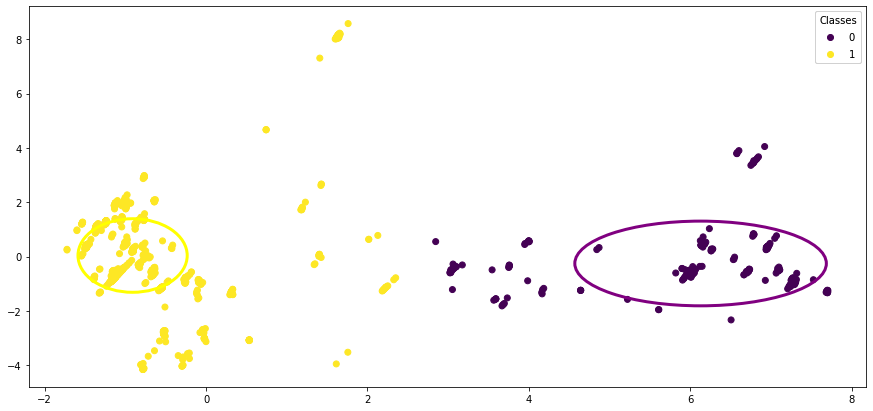

In [16]:
# Снижаем размерность до 2
pca = PCA(n_components=2)
pca.fit(scaled_features)
X = pca.transform(scaled_features)

# Соединяем полученную матрицу с номерами кластеров
array = np.concatenate((X, kmeans.labels_.reshape(len(kmeans.labels_), 1)), axis=1)

# рисуем элипсы средних значений кластеров
ellipse1 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 0, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 0, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 0, array))).std(),
                  edgecolor='purple',
                  fill=False,
                  linewidth=3)
ellipse2 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 1, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 1, array))).std() * 2, 
                  width=np.array(list(filter(lambda x: x[2] == 1, array))).std(),
                  edgecolor='yellow',
                  fill=False,
                  linewidth=3)

fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
legend = ax.legend(*scatter.legend_elements(),loc="best", title="Classes")
ax.add_artist(legend)
ax.add_patch(ellipse1)
ax.add_patch(ellipse2)

plt.show()

In [17]:
# планирую сделать графики в plotly
# fig = px.scatter(x=X[:, 0], y=X[:, 1], color=kmeans.labels_, width=800, height=600)
# fig.show(renderer="colab")

Попробуем снизить размерность исходного датафрейма до 1 и добавить на ось ординат процентную ставку по купону

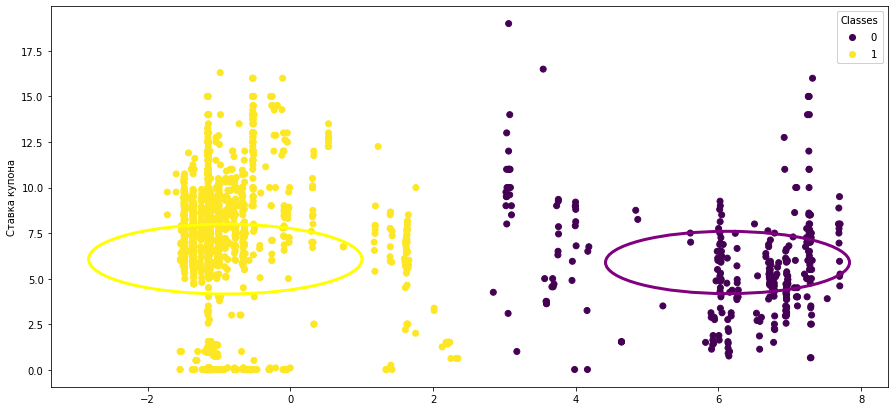

In [18]:
# Снижаю размерность до 1
pca = PCA(n_components=1)
pca.fit(scaled_features)
X = pca.transform(scaled_features)

# Соединяем полученную матрицу с номерами кластеров
array = np.concatenate((X, np.array(clustering_df.COUPONPERCENT).reshape(2396, 1), kmeans.labels_.reshape(len(kmeans.labels_), 1)), axis=1)

# рисуем элипсы средних значений кластеров
ellipse1 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 0, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 0, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 0, array))).std(),
                  edgecolor='purple',
                  fill=False,
                  linewidth=3)

ellipse2 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 1, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 1, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 1, array))).std(),
                  edgecolor='yellow',
                  fill=False,
                  linewidth=3)

fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(X, clustering_df.COUPONPERCENT, c=kmeans.labels_)
legend = ax.legend(*scatter.legend_elements(),loc="best", title="Classes")
ax.add_artist(legend)
ax.add_patch(ellipse1)
ax.add_patch(ellipse2)
ax.set_ylabel('Ставка купона')
plt.show()

### 2.2 Кластеризация низкорисковых рублевых облигаций

Оставим в датафрейме только рублевые безрисковые облигации. Удалим облигации, у которых нет цены

In [19]:
clustering_df = df.copy()
clustering_df = clustering_df[clustering_df.FACEUNIT == 'RUB']
clustering_df = clustering_df[clustering_df.IS_QUALIFIED_INVESTORS == 0]
clustering_df = clustering_df[clustering_df.HIGH_RISK == 0]
clustering_df = clustering_df[clustering_df.PRICE_RUB.notna()]

Преобразуем категориальные признаки через get_dummies

In [20]:
clustering_df = pd.get_dummies(clustering_df[CATEGORICAL_COLS + BINARY_COLS + ['PRICE', 'COUPONPERCENT']], columns=CATEGORICAL_COLS).dropna()

Отмасштабируем признаки

In [21]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_df)

Выберем оптимальное количество кластеров методом локтя по атрибуту inertia_

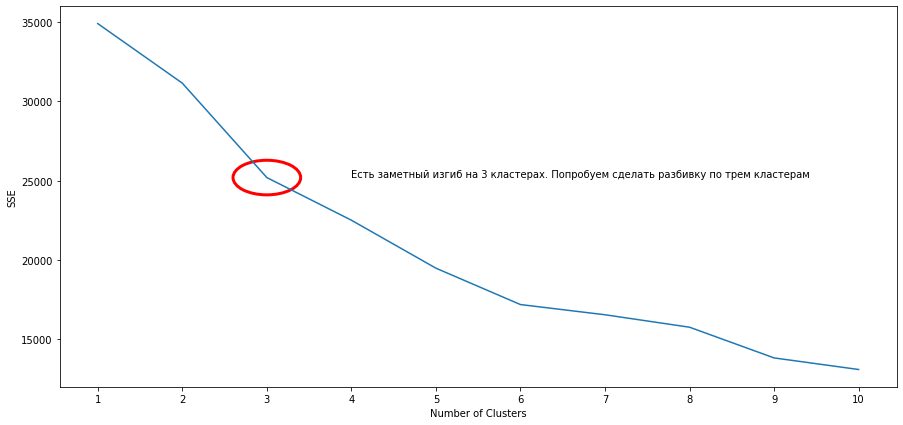

In [22]:
sse = []
kmeans_kwargs = {"init": "random",
                "n_init": 10,
                "max_iter": 300,
                "random_state": 0}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(15,7))
ellipse = Ellipse((3, sse[2]), 
                  height=(max(sse) - min(sse)) / len(sse), 
                  width=0.8,
                  edgecolor='r',
                  fill=False,
                  linewidth=3)

ax.plot(range(1, 11), sse)
ax.add_patch(ellipse)
ax.set_xticks(range(1, 11))
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE")
ax.text(x=4, y=sse[2], s='Есть заметный изгиб на 3 кластерах. Попробуем сделать разбивку по трем кластерам')

plt.show()

Обучаем модель на 3 кластера. Получаем разбиение

In [23]:
kmeans = KMeans(init="random",
                n_clusters=3,
                n_init=10,
                max_iter=300,
                random_state=0)

kmeans.fit(scaled_features)
clustering_df['Cluster'] = kmeans.labels_
clustering_df.Cluster.value_counts()

1    876
2    796
0     73
Name: Cluster, dtype: int64

Посмотрим на описание классов

In [24]:
clustering_df[clustering_df.Cluster==0].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Корпоративные еврооблигации,TYPENAME_Корпоративные облигации,TYPENAME_Муниципальные облигации,TYPENAME_ОБР,TYPENAME_ОФЗ,TYPENAME_Региональные облигации,LISTLEVEL_1,LISTLEVEL_2,LISTLEVEL_3,FACEUNIT_RUB,PRIMARY_BOARDID_TQCB,PRIMARY_BOARDID_TQOB,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,73.000000,73.0,73.0,73.000000,73.0,73.000000,73.000000,73.0,73.000000,73.0,73.0,73.000000,73.000000,73.0,73.000000,73.0,73.000000,73.0,73.000000,73.000000,73.0,73.0,73.0,73.0,73.0
mean,0.726027,0.0,0.0,0.958904,0.0,97.736438,6.426205,0.0,0.315068,0.0,0.0,0.041096,0.643836,0.0,0.808219,0.0,0.191781,1.0,0.315068,0.684932,0.0,0.0,0.0,0.0,0.0
std,0.449082,0.0,0.0,0.199886,0.0,12.167166,2.188200,0.0,0.467758,0.0,0.0,0.199886,0.482179,0.0,0.396426,0.0,0.396426,0.0,0.467758,0.467758,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.000000,0.0,20.180000,0.010000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.0,0.0,1.000000,0.0,96.430000,5.930000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,1.000000,0.0,0.0,1.000000,0.0,98.830000,6.900000,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.0,1.000000,0.0,0.000000,1.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0
75%,1.000000,0.0,0.0,1.000000,0.0,100.130000,7.650000,0.0,1.000000,0.0,0.0,0.000000,1.000000,0.0,1.000000,0.0,0.000000,1.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0
max,1.000000,0.0,0.0,1.000000,0.0,143.980000,12.250000,0.0,1.000000,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.0,1.000000,1.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0


In [25]:
clustering_df[clustering_df.Cluster==1].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Корпоративные еврооблигации,TYPENAME_Корпоративные облигации,TYPENAME_Муниципальные облигации,TYPENAME_ОБР,TYPENAME_ОФЗ,TYPENAME_Региональные облигации,LISTLEVEL_1,LISTLEVEL_2,LISTLEVEL_3,FACEUNIT_RUB,PRIMARY_BOARDID_TQCB,PRIMARY_BOARDID_TQOB,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,876.000000,876.0,876.0,876.0,876.0,876.000000,876.000000,876.000000,876.0,876.000000,876.000000,876.0,876.0,876.000000,876.0,876.0,876.0,876.0,876.0,876.0,876.000000,876.000000,876.0,876.000000,876.0
mean,0.044521,0.0,0.0,0.0,0.0,99.819224,4.628775,0.876712,0.0,0.110731,0.003425,0.0,0.0,0.009132,0.0,0.0,1.0,1.0,1.0,0.0,0.022831,0.019406,0.0,0.012557,1.0
std,0.206366,0.0,0.0,0.0,0.0,12.619266,4.635760,0.328955,0.0,0.313977,0.058454,0.0,0.0,0.095181,0.0,0.0,0.0,0.0,0.0,0.0,0.149450,0.138027,0.0,0.111416,0.0
min,0.000000,0.0,0.0,0.0,0.0,13.000000,0.010000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,1.0
25%,0.000000,0.0,0.0,0.0,0.0,94.987500,0.010000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,1.0
50%,0.000000,0.0,0.0,0.0,0.0,99.860000,4.500000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,1.0
75%,0.000000,0.0,0.0,0.0,0.0,101.695000,8.462500,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,1.0
max,1.000000,0.0,0.0,0.0,0.0,198.210000,15.000000,1.000000,0.0,1.000000,1.000000,0.0,0.0,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,1.000000,1.000000,0.0,1.000000,1.0


In [26]:
clustering_df[clustering_df.Cluster==2].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Корпоративные еврооблигации,TYPENAME_Корпоративные облигации,TYPENAME_Муниципальные облигации,TYPENAME_ОБР,TYPENAME_ОФЗ,TYPENAME_Региональные облигации,LISTLEVEL_1,LISTLEVEL_2,LISTLEVEL_3,FACEUNIT_RUB,PRIMARY_BOARDID_TQCB,PRIMARY_BOARDID_TQOB,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,796.000000,796.0,796.0,796.0,796.0,796.000000,796.000000,796.000000,796.0,796.000000,796.000000,796.0,796.0,796.000000,796.000000,796.000000,796.000000,796.0,796.0,796.0,796.000000,796.0,796.000000,796.000000,796.0
mean,0.231156,0.0,0.0,0.0,0.0,99.566256,7.578069,0.728643,0.0,0.129397,0.008794,0.0,0.0,0.133166,0.590452,0.408291,0.001256,1.0,1.0,0.0,0.032663,0.0,0.003769,0.005025,2.0
std,0.421837,0.0,0.0,0.0,0.0,5.020401,1.727378,0.444939,0.0,0.335850,0.093422,0.0,0.0,0.339967,0.492060,0.491827,0.035444,0.0,0.0,0.0,0.177866,0.0,0.061314,0.070754,0.0
min,0.000000,0.0,0.0,0.0,0.0,69.950000,0.010000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,2.0
25%,0.000000,0.0,0.0,0.0,0.0,98.117500,6.600000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,2.0
50%,0.000000,0.0,0.0,0.0,0.0,99.865000,7.600000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,1.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,2.0
75%,0.000000,0.0,0.0,0.0,0.0,100.492500,8.650000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,1.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,2.0
max,1.000000,0.0,0.0,0.0,0.0,162.760000,16.310000,1.000000,0.0,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.0,1.000000,0.0,1.000000,1.000000,2.0


##### Различие между кластерами

Можно обобщить описание у 3 кластеров:

0 кластер - ОФЗ

1 кластер - биржевые облигации 3 уровня листинга с невысокой ставкой купона

2 кластер - биржевые облигации 1 и 2 уровней листинга с высокой ставкой купона

**COUPONPERCENT**:

0 кластер - 6.42%

1 кластер - 4.62%

2 кластер - 7.57%

**TYPENAME**:

0 кластер - 64% ОФЗ

1 кластер - 88% Биржевые облигации

2 кластер - 73% Биржевые облигации

**LISTLEVEL**:

0 кластер - 100% 1 и 3 уровень

1 кластер - 100% 3 уровень

2 кластер - 100% 1 и 2 уровень


##### Нарисуем кластеры

Попробуем снизить размерность исходного датафрейма до 2

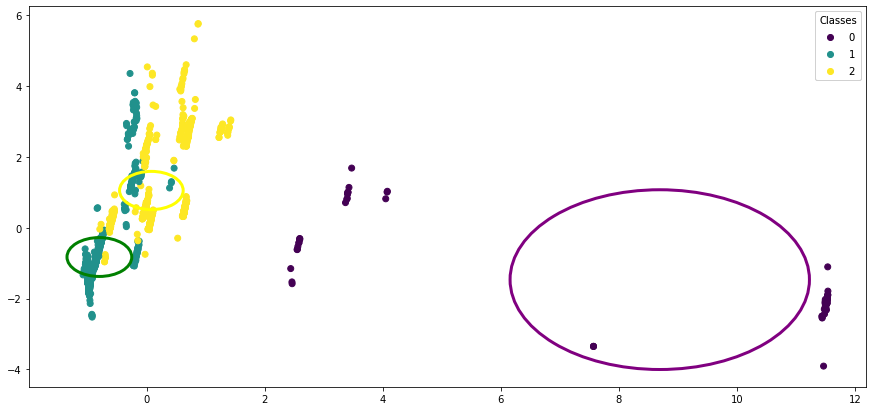

In [27]:
# Снижаем размерность до 2
pca = PCA(n_components=2)
pca.fit(scaled_features)
X = pca.transform(scaled_features)

# Соединяем полученную матрицу с номерами кластеров
array = np.concatenate((X, kmeans.labels_.reshape(len(kmeans.labels_), 1)), axis=1)

# рисуем элипсы средних значений кластеров
ellipse1 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 0, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 0, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 0, array))).std(),
                  edgecolor='purple',
                  fill=False,
                  linewidth=3)
ellipse2 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 1, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 1, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 1, array))).std(),
                  edgecolor='green',
                  fill=False,
                  linewidth=3)
ellipse3 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 2, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 2, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 2, array))).std(),
                  edgecolor='yellow',
                  fill=False,
                  linewidth=3)

fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
legend = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax.add_artist(legend)
ax.add_patch(ellipse1)
ax.add_patch(ellipse2)
ax.add_patch(ellipse3)

plt.show()


Попробуем снизить размерность исходного датафрейма до 1 и добавить на ось ординат процетную ставку по купону

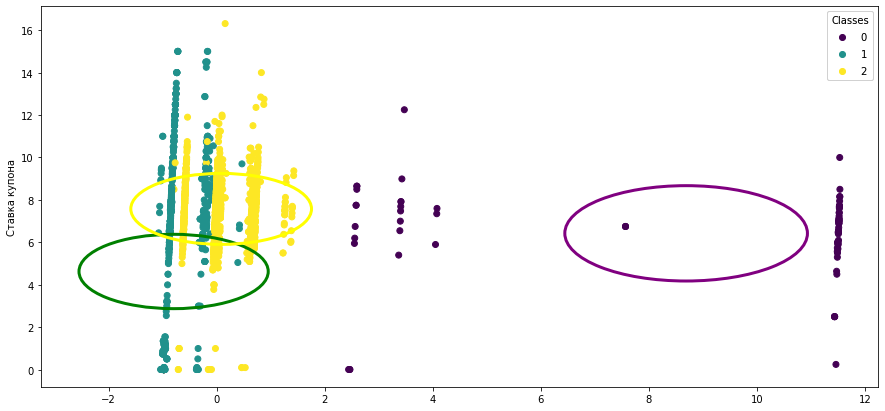

In [28]:
# Снижаем размерность до 1
pca = PCA(n_components=1)
pca.fit(scaled_features)
X = pca.transform(scaled_features)

# Соединяем полученную матрицу с номерами кластеров
array = np.concatenate((X, np.array(clustering_df.COUPONPERCENT).reshape(len(clustering_df.COUPONPERCENT), 1), kmeans.labels_.reshape(len(kmeans.labels_), 1)), axis=1)

# рисуем элипсы средних значений кластеров
ellipse1 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 0, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 0, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 0, array))).std(),
                  edgecolor='purple',
                  fill=False,
                  linewidth=3)
ellipse2 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 1, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 1, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 1, array))).std(),
                  edgecolor='green',
                  fill=False,
                  linewidth=3)
ellipse3 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 2, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 2, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 2, array))).std(),
                  edgecolor='yellow',
                  fill=False,
                  linewidth=3)

fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(X, clustering_df.COUPONPERCENT, c=kmeans.labels_)
legend = ax.legend(*scatter.legend_elements(),loc="best", title="Classes")
ax.add_artist(legend)
ax.add_patch(ellipse1)
ax.add_patch(ellipse2)
ax.add_patch(ellipse3)

ax.set_ylabel('Ставка купона')
plt.show()

# 3.Расчет доходности

Оставляем в исходном датафрейме только те облигации, по которым была произведена кластеризация

In [29]:
df = df.iloc[clustering_df.index]
df['CLUSTER'] = kmeans.labels_
df = df[['SECID', 'SHORTNAME', 'TYPENAME', 'FACEUNIT', 'FACEVALUE', 'PRICE_RUB', 'IS_QUALIFIED_INVESTORS', 'HIGH_RISK', 'COUPONDATE', 'COUPONDAYSPASSED', 'COUPONLENGTH', 'COUPONFREQUENCY', 'COUPONVALUE', 'CLUSTER', 'MATDATE']]

Фильтруем датафрейм по рублевым безрисковым облигациям, у которых прошло не более 20% от предыдущей выплаты купона.

Удаляем все пропуски

In [30]:
df = df[df.FACEUNIT == 'RUB']
df = df[df.IS_QUALIFIED_INVESTORS == 0]
df = df[df.HIGH_RISK == 0]
df = df[df.PRICE_RUB.notna()]
df = df[(df.COUPONDAYSPASSED / df.COUPONLENGTH) <= 0.2]
df.dropna(inplace=True)

Добавление новые столбцы для расчета доходности (PROFIT) на период 365 дней

In [31]:
df['MAX_INVEST_DATE'] = df.apply(lambda x: min(x.MATDATE, (date.today() + timedelta(days=INVEST_PERIOD))), axis=1)
df['INVEST_DAYS'] = df.apply(lambda x: (x.MAX_INVEST_DATE - (datetime.combine(date.today(), datetime.min.time()))).days, axis=1)
df['COUPON_INCOME'] = (df.INVEST_DAYS / INVEST_PERIOD) * df.COUPONFREQUENCY * df.COUPONVALUE
df['CURRENT_YIELD'] = df.COUPONVALUE * df.COUPONDAYSPASSED / df.COUPONLENGTH
df['PROFIT'] = (df.FACEVALUE - df.PRICE_RUB - df.CURRENT_YIELD + (1 - TAX_RATE) * df.COUPON_INCOME * 100) / (df.PRICE_RUB + df.CURRENT_YIELD)
df.sort_values(by='PROFIT', ascending=False, inplace=True)

Посмотрим на кластеры

In [32]:
df[df.CLUSTER == 0].head()

,SECID,SHORTNAME,TYPENAME,FACEUNIT,FACEVALUE,PRICE_RUB,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONDATE,COUPONDAYSPASSED,COUPONLENGTH,COUPONFREQUENCY,COUPONVALUE,CLUSTER,MATDATE,MAX_INVEST_DATE,INVEST_DAYS,COUPON_INCOME,CURRENT_YIELD,PROFIT
1703,RU000A102BF7,Продкорп01,Корпоративные еврооблигации,RUB,1000.0,1011.06,0,0,2022-03-26,12.0,181.0,2.0,44.58,0,2026-03-26,2022-10-10,365,89.16,2.955580,7.635883
2280,SU26218RMFS6,ОФЗ 26218,ОФЗ,RUB,1000.0,1081.40,0,0,2022-03-30,9.0,182.0,2.0,42.38,0,2031-09-17,2022-10-10,365,84.76,2.095714,6.728798
2281,SU26219RMFS4,ОФЗ 26219,ОФЗ,RUB,1000.0,1019.30,0,0,2022-03-23,16.0,182.0,2.0,38.64,0,2026-09-16,2022-10-10,365,77.28,3.396923,6.551954
2292,SU26230RMFS1,ОФЗ 26230,ОФЗ,RUB,1000.0,1016.82,0,0,2022-06-04,2.0,182.0,2.0,38.39,0,2039-03-16,2022-10-10,365,76.78,0.421868,6.549689
1410,RU000A101RZ3,Казахст11,Корпоративные еврооблигации,RUB,1000.0,934.67,0,0,2022-03-23,16.0,182.0,2.0,34.90,0,2030-11-09,2022-10-10,365,69.80,3.068132,6.542191


In [33]:
df[df.CLUSTER == 1].head()  

,SECID,SHORTNAME,TYPENAME,FACEUNIT,FACEVALUE,PRICE_RUB,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONDATE,COUPONDAYSPASSED,COUPONLENGTH,COUPONFREQUENCY,COUPONVALUE,CLUSTER,MATDATE,MAX_INVEST_DATE,INVEST_DAYS,COUPON_INCOME,CURRENT_YIELD,PROFIT
1043,RU000A100TL1,Кузина1P01,Биржевые облигации,RUB,7620.0,7848.85,0,0,2021-04-11,3.0,30.0,12.0,93.95,1,2023-08-26,2022-10-10,365,1127.400000,9.395000,12.451324
1214,RU000A1018L9,ЗавдКЭС1P1,Биржевые облигации,RUB,1000.0,1034.52,0,0,2021-12-21,17.0,91.0,4.0,34.90,1,2022-12-20,2022-10-10,365,139.600000,6.519780,11.626991
1056,RU000A100V38,МоторТ1Р01,Биржевые облигации,RUB,1000.0,1053.88,0,0,2021-12-22,16.0,91.0,4.0,37.40,1,2022-09-21,2022-09-21,346,141.812603,6.575824,11.577324
295,RU000A0JWB59,Держава 03,Корпоративные облигации,RUB,1000.0,1109.43,0,0,2022-03-18,21.0,182.0,2.0,74.79,1,2036-02-29,2022-10-10,365,149.580000,8.629615,11.533732
1465,RU000A101UL7,ГЕНЕТИКБ01,Биржевые облигации,RUB,1000.0,1066.92,0,0,2021-12-27,11.0,91.0,4.0,34.90,1,2025-06-23,2022-10-10,365,139.600000,4.218681,11.272174


In [34]:
df[df.CLUSTER == 2].head()

,SECID,SHORTNAME,TYPENAME,FACEUNIT,FACEVALUE,PRICE_RUB,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONDATE,COUPONDAYSPASSED,COUPONLENGTH,COUPONFREQUENCY,COUPONVALUE,CLUSTER,MATDATE,MAX_INVEST_DATE,INVEST_DAYS,COUPON_INCOME,CURRENT_YIELD,PROFIT
1471,RU000A101UW4,Соц.разв02,Корпоративные облигации,RUB,854.2,965.93,0,0,2022-08-01,0.0,92.0,4.0,35.12,2,2027-08-01,2022-10-10,365,140.48,0.000000,12.537171
236,RU000A0JVM81,Оренб35003,Региональные облигации,RUB,800.0,907.35,0,0,2022-06-01,1.0,91.0,4.0,27.92,2,2025-03-07,2022-10-10,365,111.68,0.306813,10.586053
252,RU000A0JVUD3,Новсиб 7об,Муниципальные облигации,RUB,200.0,205.94,0,0,2021-12-23,15.0,91.0,4.0,6.16,2,2022-10-10,2022-10-10,365,24.64,1.015385,10.324566
153,RU000A0JUJG1,Росбн14ИП,Корпоративные облигации,RUB,500.0,546.46,0,0,2021-12-27,11.0,91.0,4.0,14.96,2,2024-03-27,2022-10-10,365,59.84,1.808352,9.407458
1470,RU000A101UU8,Соц.разв01,Корпоративные облигации,RUB,854.2,854.20,0,0,2022-08-01,0.0,92.0,4.0,21.98,2,2027-08-01,2022-10-10,365,87.92,0.000000,8.954624


В качестве предложения выберем следующую стратегию:

**Основной признак качественного инвенстиционного портфеля является диверсификация.**
**Для диверсификации портфеля облигаций воспользуемся следующим методом. Кластериуем облигации на 3 класс, а затем возьмем одинаковое количество ценных бумаг из каждого кластера. Доходность портфеля будем определять, как сумму купонного дохода по всем облигациям**


In [35]:
final_bonds = pd.concat([df[df.CLUSTER == 0][['SECID', 'SHORTNAME', 'TYPENAME', 'FACEVALUE', 'PRICE_RUB','INVEST_DAYS', 'COUPON_INCOME', 'CURRENT_YIELD', 'PROFIT']].head(5),
                         df[df.CLUSTER == 1][['SECID', 'SHORTNAME', 'TYPENAME', 'FACEVALUE', 'PRICE_RUB','INVEST_DAYS', 'COUPON_INCOME', 'CURRENT_YIELD', 'PROFIT']].head(5),
                         df[df.CLUSTER == 2][['SECID', 'SHORTNAME', 'TYPENAME', 'FACEVALUE', 'PRICE_RUB','INVEST_DAYS', 'COUPON_INCOME', 'CURRENT_YIELD', 'PROFIT']].head(5)])

final_bonds.sort_values(by='PROFIT', ascending=False, inplace=True)

# 4.Визуализация

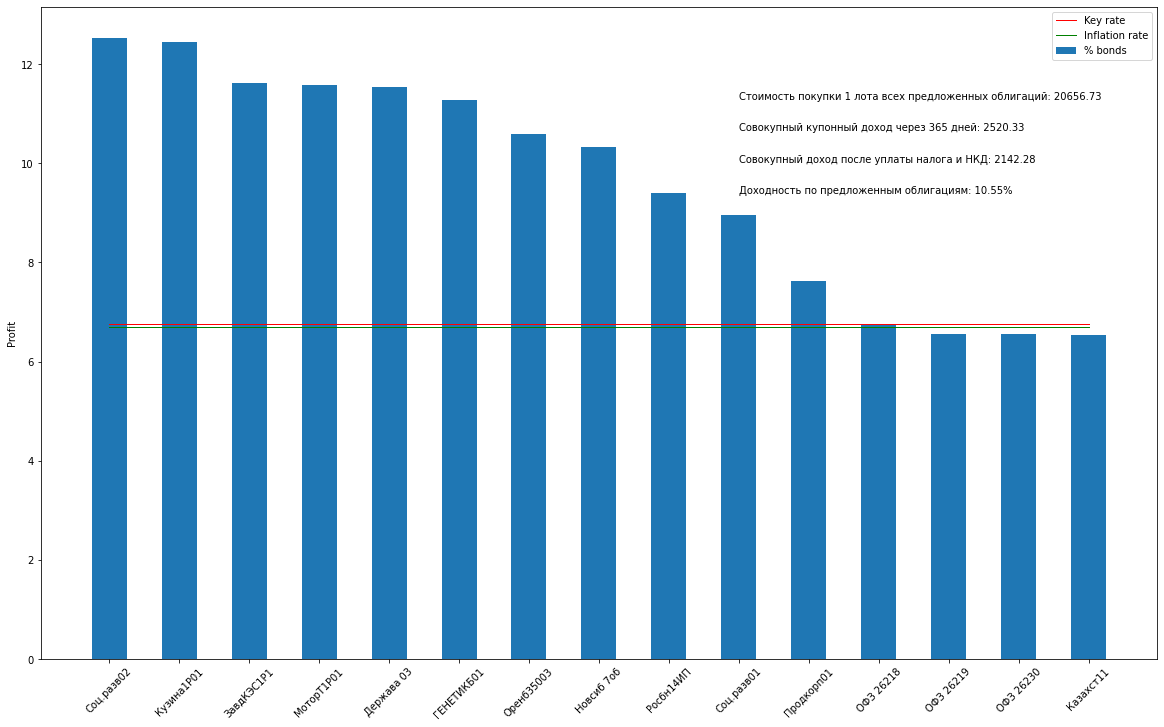

In [36]:
facevalue = final_bonds[['FACEVALUE']].sum().values[0]
price = final_bonds[['PRICE_RUB']].sum().values[0]
income = final_bonds[['COUPON_INCOME']].sum().values[0]
current_yeild = final_bonds[['CURRENT_YIELD']].sum().values[0]
fig, ax = plt.subplots(figsize=(20,12))

ax.bar(final_bonds.SHORTNAME.values, height=final_bonds.reset_index().PROFIT.values, width=0.5, label='% bonds')
ax.plot([KEY_RATE] * len(final_bonds), color='r', linewidth=1, label='Key rate')
ax.plot([INFLATION_RATE] * len(final_bonds), color='g', linewidth=1, label='Inflation rate')
ax.text(9, final_bonds.PROFIT.max() * 0.90, f'Стоимость покупки 1 лота всех предложенных облигаций: {round(price, 2)}')
ax.text(9, final_bonds.PROFIT.max() * 0.85, f'Совокупный купонный доход через 365 дней: {round(income, 2)}')
ax.text(9, final_bonds.PROFIT.max() * 0.8, f'Совокупный доход после уплаты налога и НКД: {round(income * (1 - TAX_RATE) - current_yeild, 2)}')
ax.text(9, final_bonds.PROFIT.max() * 0.75, 
        f'Доходность по предложенным облигациям: {round((facevalue - price - current_yeild + (1 - TAX_RATE) * income * 100) / (price + current_yeild), 2)}%')

ax.set_xticks(range(0, 15))
ax.set_ylabel("Profit")

plt.xticks(rotation=45)
ax.legend()
plt.show()